## Pre-Requisites

* For Basics Check the [1st Notebook](https://github.com/suvoooo/Learn-TensorFlow/blob/master/TF-Proba/Norm-Flows/Normalizing%20Flows_GettingStarted.ipynb): 


  What topics are covered before: 
  1. Probability & Linear Algebra; 
  2. Change of Variable and Jacobian;
  3. Example of Bijection operations: Forward and Inverse Method w TensorFlow Probability.  



The two main formulas that we already went through step by step are called Change of Vairables formula--

$$\text{log}\, p_X(x) = \log p_U(u) − \log|\det \, J_ϕ (u)|\, ......\, (eq: 1)$$

where We remember our transformation from $u$ to $x$ via mapping function $ϕ$ as $x=ϕ(u);\, u=ϕ^{-1}\, (x)$

$$\log p_U(u) = \log p_X(x) − \log |\det J_{ϕ^{−1}}(x)|\, ......\, (eq: 2)$$

 

* Examples of Transforming Distrbutions are discussed in the [2nd Notebook](https://github.com/suvoooo/Learn-TensorFlow/blob/master/TF-Proba/Norm-Flows/NormFlow_TransformDistribution.ipynb). 

  1. We've used `TransformedDistribution` class to go through examples of transforming simple Normal to Bi-Modal distribution. 
  2. How to write custom bijector class just like keras custom layers and define Forward & Inverse transformations and Forward Log-det Jacobian. 


These are the primers necessary to discuss any models based on Normalizing Flows. Bijection, Jacobian, Transforming distributions and change of variables rule and the transforming simple Normal distribution to Bi-Modal distribution using TensorFlow; everything discussed so far are extremely important to understand the next steps. Even though we have used only one bijector for transforming Normal to Bi-Modal distribution, we know that one can chain various bijectors together. Thus, it's possible to create very complicated bijectors that change standard distributions (e.g. a normal) to very complicated ones. Once again, This is how a normalizing flow works: it creates a complicated distribution by applying a bijector to a simple, well-understood and computationally implemented distribution. 

-----------------------------------------------------

## 1. Models based on Normalizing Flows 



Before we discuss the models such as Autoregressive Flows etc., let's setup the proper change of variable rules for 1D and higher Dimensional scenarios. 

As discussed [before](https://github.com/suvoooo/Learn-TensorFlow/blob/master/TF-Proba/Norm-Flows/Normalizing%20Flows_GettingStarted.ipynb) if we start from a base distribution $u$ and a bijector $\phi$ such that $x = \phi(u)$, then the change of variables rule is as follows: 

$$\log \, p_X(x) = \log\, p_U(u) - \log \left|\frac{\partial \phi (u)}{\partial u}\right|\,  ......\, (eq: 3) $$

For Normalizing Flows we compose several bijectors to a more complicated one 

$$\begin{align} &\phi = \phi _k  \cdot   \phi _{k-1}  \cdot  \phi _{k-2} \ldots \phi _1\, \\ &\text{where}\, \, u_k = \phi _k (u _{k-1}); \, \,  k = 1, 2, \ldots K \\ &\text{base distribution } u_0, \, \& \, \, x = u_K\end{align} \, \, ......\, (eq: 4)$$

Here, $u_k = \phi _k(u_{k-1}); \, k = 1, 2, \ldots K$ and $u_0$ represents the base distribution, so $x = u_K$. 

We can modify the change of variables formula as below: 

$$\log \, p_X(x) = \log\, p_U(u) - \sum _{k=1}^{K}\log \, \left|\frac{\partial \phi_k\, (u_k)}{\partial u_{k-1}}\right|\, ......\, (eq: 5)$$. 

To quote from [D. Rezende's paper](https://arxiv.org/pdf/1505.05770.pdf):

>We can understand the effect of invertible flows as a se-
quence of expansions or contractions on the initial density.
For an expansion, the map $ u' = \phi (u)$ pulls the points $u$
away from a region in $\mathbb{R}^d$, reducing the density in that region while increasing the density outside the region. Conversely, for a contraction, the map pushes points towards the interior of a region, increasing the density in its interior while reducing the density outside. 

One of the biggest issues with implementing Normalizing Flows is the computational complexity of the log-det-jacobian. Calculating the determinant of the Jacobian of a $n\times n$ via process like Gaussian Elimination has a [runtime complexity](https://en.wikipedia.org/wiki/Gaussian_elimination#Computing_determinants) of $\mathcal{O}(n^3)$. 

So we need some simplifications in the procedures described above and we can now move to learn some of the simplifications that will help us reducing the computational complexity. 

----------------------------------------------------

### 2. Triangualr Matrix and Autoregressive Flow:

For both upper and lower triangular matrices the determinant will just be the product of diagonal elements. Let's consider $3\times 3$ matrices

$$det \left(\begin{matrix} {\color{seagreen}{\textbf{a}}} & b & c \\ 0 & \color{seagreen}{\textbf{e}} & f \\ 0 & 0 & {\color{seagreen}{\textbf{i}}} \end{matrix} \right)\, = \color{seagreen}{aei}\, \, \, ; \, \, det \left(\begin{matrix} \color{seagreen}{\textbf{a}} & 0 & 0 \\ d & \color{seagreen}{\textbf{e}} & 0 \\ g & h & \color{seagreen}{\textbf{i}} \end{matrix} \right)\, = \color{seagreen}{aei}\, \, ......\, (eq: 6) $$

Now this calculation is linear i.e. if the square matrix has dimension $n$, the runtime complexity has been reduced to $\mathcal{O}(n)$. 

Let's consider the lower triangular matrix where $a_{ij}=0; \, j>i$. We impose a very similar concept in Autoregressive flows. 

We consider a $D$ dimensional vector $u$ and it goes through $1, \, 2,\, \ldots\, K $ transformations just as before.    
 
_Side Note: look back at the [1st Notebook](https://github.com/suvoooo/Learn-TensorFlow/blob/master/TF-Proba/Norm-Flows/Normalizing%20Flows_GettingStarted.ipynb) where we started as a $D$ dimensional vector $x$ and we said that he main idea of flow-based modeling is to express $x$ as a transformation $\phi$ of a real vector $u$ sampled from $p_u(u): \, x = \phi (u)$, and we said that the definition of diffeomorphism requires $u$ to be $D$ dimensional as well. So when we say here $u$ as a $D$ dimensional vector, we are saying that the base distribution is $D$ dimensional and so will the final distribution be $x$_  

The Autoregressive-Flow condition is that $\frac{\partial u_k ^{(d)}}{\partial u_{k-1} ^{(>d)}}==0$, so our triangular matrix looks as below: 

$$\frac{\partial u_k ^{(d)}}{\partial u_{k-1} ^{(>d)}}==0\implies  \left(\begin{matrix} \frac{\partial u_k ^{(1)}}{\partial u_{k-1} ^{(1)}} & 0 & \ldots & 0 \\ \frac{\partial u_k ^{(2)}}{\partial u_{k-1} ^{(1)}} & \frac{\partial u_k ^{(2)}}{\partial u_{k-1} ^{(2)}} & \ldots & 0 \\ \vdots & \ldots & \ldots & \vdots \\ \frac{\partial u_k ^{(D)}}{\partial u_{k-1} ^{(1)}} & \ldots & \ldots &\frac{\partial u_k ^{(D)}}{\partial u_{k-1} ^{(D)}} \end{matrix} \right)\, ......\, (eq: 7)$$



If you have ever used ARIMA models for time series analysis, then you know that the _autoregressive_ term suggests the time series is based on the past values. So we can constraint sequential data $[x_1, x_2, \, \ldots , x_D]$ where each output (at a particular step) only depends on the observed values before and not the future ones. In a more mathematical notation this would be probability of observing $x_i$ conditioned on $x_1, \ldots , x_{i-1}$ and the product of these conditional probabilities gives us the probability of observing the full sequence: 

$$p(X) = \prod _{i=1}^D \, p\left(x_i| x_1, \ldots, x_{i-1} \right) = \prod _{i=1}^D p\left(x_i|x_{1:i-1}\right)......\, (eq: 8)$$

The modeling of this conditional density is of our choice and several proposals have been made from simple univariate Gaussian to neural network. 
 
---------------------------------------------------------------

### 3. Masked Autoregressive Flow (MAF)
If we take for example Normal distribution to model this conditionals then we can write for the $i$th conditional: 

$$p(x_i|x_{1:i-1}) = \mathcal{N}\left(x_i|\mu _i, (\text{exp}\, \alpha _i)^2 \right) \, ......\, (eq: 9)$$

where $\mu _i = f_{\mu _i}(x_{1:i-1}), \, \alpha _i = f_{α_i}(x_{1:i-1})$ and the functions $f_{\mu _i}, \, f_{α_i}$ are unconstrained scalar functions that compute the mean and log standard deviation of the $i$th conditional given all previous variables. Using this we can also generate new data as below:

$$\begin{align}& x_i = u_i\,  \text{exp}\, α_i + \mu _i ,  \\ &\text{where}\, \,  μ_i = f_{μ_i} \left(x_{1:i−1}\right),\,\\ & α_i = f_{α_i} \left(x_{1:i−1}\right),\, \\ &\text{and},\,\, u_i ∼ \mathcal{N}(0, 1)\end{align} \, ......\, (eq: 10)$$

In the above, $u = (u_1, u_2,\ldots , )$ is the vector of random numbers the model uses internally to generate data, typically by making calls to a random number generator often called `randn()`. 

Eq. (10) provides an alternative characterization of the autoregressive model as a transformation $f$ from the space of random numbers $u$ to the space of data $x$. That is, we can express the model as $x = f(u)$ where $u ∼ \mathcal{N} (0, I)$. By construction, $f$ is easily invertible. 

**_The above part from eq. 9 till here is from the [Masked AutoRegressive Flow for Density Estimation paper](https://arxiv.org/pdf/1705.07057.pdf)_**. 

The variables $\mu_i, \, \alpha_i$ are calculated by passing $x_{1:i-1}$ through neural-nets. Since the transformations are just mere scale & shift, to get back our base variables $u_i$, we don't need to invert the functions themselves. This is also mentioned in MADE paper: 

$$u_i = \left(x_i - \mu _i \right)\,  \text{exp}\, \left(-α_i\right) , \, \text{where}\, \,  μ_i = f_{μ_i} \left(x_{1:i−1}\right),\, α_i = f_{α_i} \left(x_{1:i−1}\right),\, \, ......\, (eq: 11)$$

**This is extremely important for training strategy as we do not need to explicitly calculate the inverse of the functions $f_{\alpha _i},\, f_{\mu _i}$, and just need to evaluate them once (say during forward pass), we can use non-invertible functions like RELU.**

An excellent image of the forward pass (and the inverse pass) is given in [_Eric Jang's blog_](https://blog.evjang.com/2018/01/nf2.html): 

![made](https://drive.google.com/uc?id=1qAsI0oFSMCPoxLffbw9mlxQbH8eUQwiP)


-------------------------------------------------------

### 4. Inverse Autoregressive Flow (IAF)

The transformations for IAF in MADE paper is defined as below: 

$$\begin{align} &x_i = u_i\,  \text{exp}\, α_i + \mu _i , \, \\ \\ &\text{where}\, \,  μ_i = f_{μ_i} \left(u_{1:i−1}\right),\, α_i = f_{α_i} \left(u_{1:i−1}\right),\, \end{align} \, ......\,  (eq: 12)$$

Readily we see the difference from MADE (eq. 10) is that the scaling $(\alpha _i)$ and shift variables $(\mu _i)$ were previously computed using the data variables $(x_{1:i-1})$, but here it's done using the previous random numbers $(u_{1:i-1})$  

Once again we make use of an excellent pictorial representation from Eric Jang's blog for IAF. 

![IAF](https://drive.google.com/uc?id=1Jierwz-8_Q0KI9VhNI8WUl0Yy_ReuF56)


Now we see the uncanny similarity between the MADE structure and the IAF and that is the inverse of the IAF is the forward pass of the MAF. This would be exactly how we can implement the IAF bijector in TensorFlow; after defining the MAF bijector we can just invert it using `tfb.Invert(maf_bijector)`



---------------------------------------------

### 5. Real NVP (Real-Valued Non Volume Preserving)

The [RealNVP paper](https://arxiv.org/pdf/1605.08803.pdf) was actually published before MAF and it also uses the generic autoregressive structure where the transformation matrix (Jacobian) is triangular. 

Here the difference from the MAF bijector is that, given the $D$ dimensional input we select a $d; \, 0 < d < D$ and for the first $d$ dimensions, no transformations are applied to the base distribution, but for remaining $D-d$ dimensions, we apply the exact same affine transformations (scale and shift) as in MAF. So we can summarize this as below: 

$$\begin{align} x_{i} = u_{i}&; \, i = 1, \ldots d; \\ \, \, \, x_{i} = u_i \, \text{exp}\, \alpha _i + \mu _i&; \, i = d+1, \ldots D.\, \text{where}\, \, \alpha _i = f_{\alpha _i}(u_{1:d}), \, \, \mu _i = f_{\mu _i}(u_{1:d}) \end{align}\,  \, ......\, (eq: 13)$$

An informative pictorial representation of the forward and inverse pass are given in the original paper as below: 

![RealNVP](https://drive.google.com/uc?id=1BF2gP-TinTw-KLQiWr5zPDM-ummtWaOK)

$t, s$ in pictures are same as $\mu , \, \alpha$ respectively and $x, y$ are same as $u, x$ respectively in the equations above. Why it is called non-volume preserving is because the transformation that is involved (affine) can only be volume preserving if $\text{det}\,| \text{Jacobian}| == 1$, but if we focus on the Jacobian (also described in the paper): 

$$\det \left[\begin{matrix} \mathbb{I_{1:d/1:d}} & 0_{1:d/d+1:D}  \\ \left(\frac{\partial y}{\partial u}\right)_{d+1:D/1:d} & \text{diag}\, \left(\text{exp}\, f_{\alpha _i}(u_{1:d})\right)_{d+1:D/d+1:D}   \end{matrix} \right]\, \, \, ;$$

we see that it's a triangular matrix and it certainly not equals to 1. 

Another very important point related to the transformation matrix is that, we don't need to explicitly calculate the Jacobian of $f_{\alpha _i}, f_{\mu _i}$ and this gives us the freedom to choose arbitrarily complex functions i.e. neural nets!!!   



Also at this stage it is very important to highlight that when we chain the transformations $1, 2, \ldots K$ and from the matrix above (eq. 7) we can see that it is necessary to permute the bijectors to swap the order of dimensions. Otherwise we cannot ensure how the dimensions influence each other if the ordering of the dimensions never change and it greatly reduces the expressive power of chaining bijectors in normalizing flows. This will be true for any autoregressive models (maf, real-nvp etc.) due to the triangular matrix structure of Jacobian. 

In [ ]:
import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120
import matplotlib.ticker as tick
import seaborn as sns 

from sklearn import datasets
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras import Model
from tensorflow.keras.callbacks import LambdaCallback, EarlyStopping
import tensorflow_probability as tfp


tfd = tfp.distributions
tfb = tfp.bijectors

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

path_to_file='/content/drive/My Drive/Colab Notebooks/'

Mounted at /content/drive


check shapes:  (1600, 2) (1600,)
check max & min brefore norm:  1.133722160051601 -1.125576925214142
check shapes after normed:  (1600, 2) (1600,)
check dtypes of X and Y after normed: float64 int64
check max & min after norm:  1.60806053106577 -1.5914358243352724


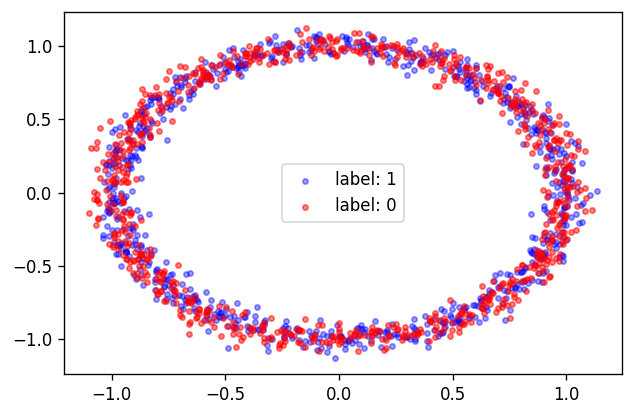

In [ ]:
circle_dataset = datasets.make_circles(noise=0.05, factor=0.99, random_state=1, n_samples=1600)
X_circle, Y_circle = circle_dataset
print ('check shapes: ', X_circle.shape, Y_circle.shape)
print ('check max & min brefore norm: ', X_circle.max(), X_circle.min())
X_circle_normed = StandardScaler().fit_transform(X_circle)
print ('check shapes after normed: ', X_circle_normed.shape, Y_circle.shape, )
print ('check dtypes of X and Y after normed:', X_circle_normed.dtype, Y_circle.dtype)
print ('check max & min after norm: ', X_circle_normed.max(), X_circle_normed.min())


Y_circle = Y_circle.astype('bool')
X_train_c, Y_train_c = X_circle[..., 0], X_circle[..., 1]

fig = plt.figure(figsize=(6, 4))
fig.add_subplot(111)
plt.scatter(X_train_c[Y_circle], Y_train_c[Y_circle], s=10, color='blue', alpha=0.4)
plt.scatter(X_train_c[Y_circle == False], Y_train_c[Y_circle == False], s=10, color='red', alpha=0.5)
plt.legend(['label: 1', 'label: 0'])
plt.show()

In [ ]:
ns = X_circle_normed.shape[0]
y = np.zeros((ns, 0), dtype=np.float32)
print (y.shape, y)
y[5:10]

y_empty = np.empty((ns, 0), dtype=np.float32)
print (y_empty.shape, y_empty)
y_empty[5:10]

(1600, 0) []
(1600, 0) []


array([], shape=(5, 0), dtype=float32)

In [ ]:
normal_check = tf.random.normal([3, 2])
print ('normal distribution shape: ', tf.shape(normal_check))
print (normal_check)
print ('\n')

def check_made(hidden_units=[64, 64], activation='relu'):
    made = tfb.AutoregressiveNetwork(params=2, event_shape=[2], hidden_units=hidden_units, 
                                    activation=activation)
    return made

check_made_normal = check_made(hidden_units=[64, 64], activation='sigmoid')(normal_check)
print ('after applying AutoregressiveNetwork class: ', '\n', tf.shape(check_made_normal))

permute = tfb.Permute(permutation=[1, 0])

print ('check before permute: ', check_made_normal)
print ('check shapes after permute: ', tf.shape(permute.forward(check_made_normal)), '\n', permute.forward(check_made_normal),) # swaps the axis 
# this is necessary in chaining bijector operations to allow different dimensions influencing each other

normal distribution shape:  tf.Tensor([3 2], shape=(2,), dtype=int32)
tf.Tensor(
[[ 0.2849528  -1.4792933 ]
 [-0.29356614  0.6090413 ]
 [-1.8387877  -0.81261486]], shape=(3, 2), dtype=float32)


after applying AutoregressiveNetwork class:  
 tf.Tensor([3 2 2], shape=(3,), dtype=int32)
check before permute:  tf.Tensor(
[[[ 0.          0.        ]
  [-0.14136362  0.05348873]]

 [[ 0.          0.        ]
  [-0.14164376  0.0602451 ]]

 [[ 0.          0.        ]
  [-0.14217371  0.07833022]]], shape=(3, 2, 2), dtype=float32)
check shapes after permute:  tf.Tensor([3 2 2], shape=(3,), dtype=int32) 
 tf.Tensor(
[[[ 0.          0.        ]
  [ 0.05348873 -0.14136362]]

 [[ 0.          0.        ]
  [ 0.0602451  -0.14164376]]

 [[ 0.          0.        ]
  [ 0.07833022 -0.14217371]]], shape=(3, 2, 2), dtype=float32)


Few notes on the above code block: 

Let's say our data distribution is $D$ dimensional. Base distribution is normal

```
u~ N(0, 1)
x[i] = u[i] * scale(x[0:i-1]) + loc(x[0:i-1]), i=0,...,D-1  
```

`AutoRegressiveNetowrk` class is an implementation of MADE architecture. The neural network has two hidden layers with 64 units each and we used `sigmoid` activation function. 

Let's say if we pass in an input with shape `(3, 2)`, i.e. batch of 3 input datapoints each of length 2, then the returned output by `check_made` function will have shape `(3, 2, 2)`. The added dimension 2 is coming from `params` argument. For each element in the batch the network outputs 2 elements of length 2. So the first of this could be used for mean and the second could be used for log of std. dev. We have verified this above. 

Once we've defined the autoregressive network, we can use that to define the masked autoregressive flow. Within TensorFlow Probability the `MaskedAutoRegressiveFlow` bijector can do this and for the affine transformation (i.e. shift and scale) we use the pre-defined `AutoRegressiveNetwork` class.

```
maf = tfb.MaskedAutoRegressiveFlow(shift_and_log_scale_fn=check_made)
```

Once we have the bijector defined, as before (check [previous notebook](https://github.com/suvoooo/Learn-TensorFlow/blob/master/TF-Proba/Norm-Flows/NormFlow_TransformDistribution.ipynb)), we can use the `TransformedDistribution` class to transfer our base distribution (e.g. normal) via the masked autoregressive flow bijector. 

For more, please check the [TensorFlow page](https://www.tensorflow.org/probability/api_docs/python/tfp/bijectors/MaskedAutoregressiveFlow). 

In [ ]:
# Define base distribution

base_distribution = tfd.Normal(loc=0., scale=1.)
print ('check shape of base distribution: ', base_distribution)

# # Define the trainable distribution

def make_maf(hidden_units=[32, 32], activation='relu'):
    made = tfb.AutoregressiveNetwork(params=2, event_shape=[2], hidden_units=hidden_units, 
                                    activation=activation) 
    return tfb.MaskedAutoregressiveFlow(shift_and_log_scale_fn=made)

activation='relu'
masked_auto_f = tfd.TransformedDistribution(distribution=tfd.Sample(base_distribution, sample_shape=[2]), bijector=make_maf(activation=activation), 
                                            name='Masked AutoReg Flow: Activation:%s'%(activation))
print ('what about the transformed distribution: ', masked_auto_f)

check shape of base distribution:  tfp.distributions.Normal("Normal", batch_shape=[], event_shape=[], dtype=float32)
what about the transformed distribution:  tfp.distributions._TransformedDistribution("Masked_AutoReg_Flow_Activation_relu", batch_shape=[], event_shape=[2], dtype=float32)


In [ ]:
print (masked_auto_f.name)

Masked_AutoReg_Flow_Activation_relu


Let's apply the forward transformation of our bijector on the base distribution and plot example results. 

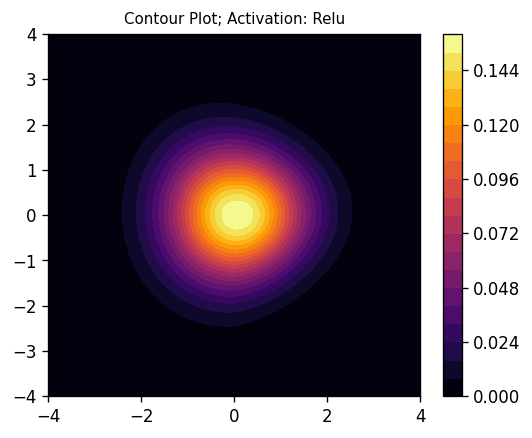

In [ ]:
def contour_plot(dist, title, up_lim=4., low_lim=-4.,):
  xx = np.linspace(low_lim, up_lim, 100)
  yy = np.linspace(low_lim, up_lim, 100)
  X, Y = np.meshgrid(xx, yy)

  Z = dist.prob(np.dstack((X, Y))).numpy()

  plt.subplots( figsize=(5, 4))
  plt.contourf(X, Y, Z.reshape(X.shape), 20, cmap='inferno')
  plt.colorbar()
  plt.title('Contour Plot; Activation: ' + str(title), fontsize=9)
  plt.show()


maf = masked_auto_f
contour_plot(maf, 'Relu',)

check sample shape:  (1500, 2)
['Normal', 'Masked_AutoReg_Flow_Activation_relu', 'Masked_AutoReg_Flow_Activation_sigmoid']
(1500, 2) (1500, 2) (1500, 2)


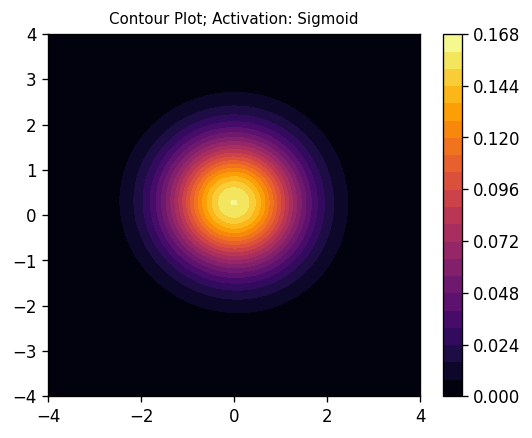

In [ ]:
# Make samples

x = base_distribution.sample((1500, 2))
print ('check sample shape: ',  x.shape)

activation_s='sigmoid'
masked_auto_f_sigmoid = tfd.TransformedDistribution(distribution=tfd.Sample(base_distribution, sample_shape=[2]), bijector=make_maf(activation=activation_s), 
                                            name='Masked AutoReg Flow: Activation:%s'%(activation_s))

names = [base_distribution.name, masked_auto_f.name, masked_auto_f_sigmoid.name]
print (names)
samples = [x, masked_auto_f.bijector.forward(x), masked_auto_f_sigmoid.bijector.forward(x)] # samples from base distribution and from transformed distribution 
print (samples[0].shape, samples[1].shape, samples[2].shape)

maf_sigmoid = masked_auto_f_sigmoid


contour_plot(maf_sigmoid, 'Sigmoid',)

3 1


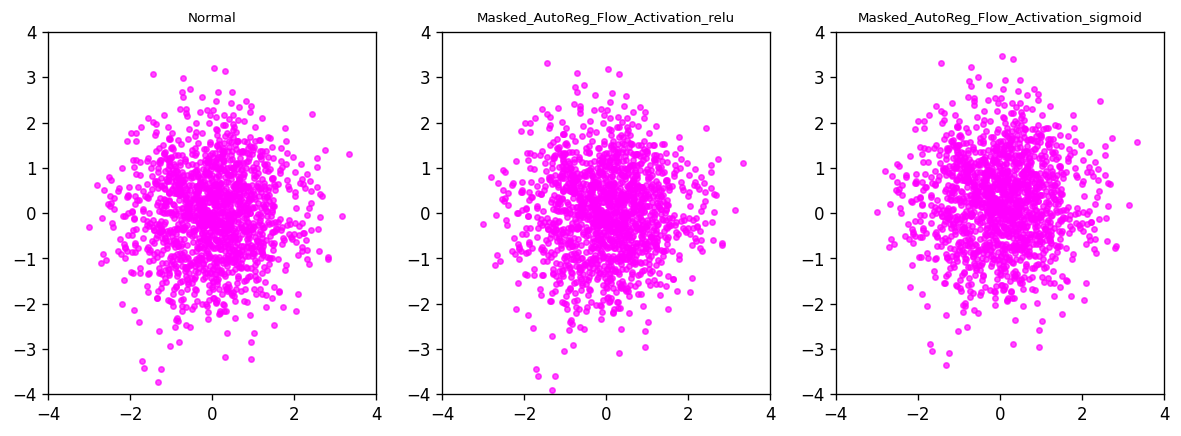

In [ ]:
# Define a scatter plot routine for the bijectors

def scatter_plot(results, names_list, rows=1, legend=False):
    cols = int(len(results) / rows)
    print (cols, rows)
    f, arr = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
    i = 0
    for r in range(rows):
        for c in range(cols):
            res = results[i]
            X, Y = res[..., 0].numpy(), res[..., 1].numpy()
            if rows==1: p = arr[c]
            else: p = arr[r, c]
            p.scatter(X, Y, s=10, color='magenta', alpha=0.7)
            p.set_xlim([-4, 4])
            p.set_ylim([-4, 4])
            p.set_title(names_list[i], fontsize=8)
            
            i += 1
scatter_plot(samples, names)

### Training the MAF Bijector 



In [ ]:
# Define a training routine

def train_dist_routine(trainable_distribution, n_epochs=200, batch_size=None, n_disp=100):
    x_ = Input(shape=(2,), dtype=tf.float32)
    log_prob_ = trainable_distribution.log_prob(x_)
    model = Model(x_, log_prob_)
    # the loss function is log likelihood

    model.compile(optimizer=tf.optimizers.Adam(learning_rate=5e-3),
                  loss=lambda _, log_prob: -log_prob)

    if batch_size is None:
        batch_size = int(ns/10) # sample size/10

    # Display the loss every n_disp epoch
    epoch_callback = LambdaCallback(on_epoch_end=lambda epoch, logs: 
                                    print('\n Epoch {}/{}'.format(epoch+1, n_epochs, logs), 
                                          '\n\t ' + (': {:.4f}, '.join(logs.keys()) + ': {:.4f}').format(*logs.values()))
                                    if epoch % n_disp == 0 else False)
    
    es = EarlyStopping(monitor='val_loss', patience=50, verbose=1, min_delta=1e-6)


    history = model.fit(x=X_circle_normed,
                        y=y_empty,
                        batch_size=batch_size,
                        epochs=n_epochs,
                        validation_split=0.2,
                        shuffle=True,
                        verbose=False,
                        callbacks=[epoch_callback, es])
    return history

# Train the distribution

history = train_dist_routine(masked_auto_f_sigmoid, n_epochs=500, n_disp=50)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089



 Epoch 1/500 
	 loss: 2.8557, val_loss: 2.8356

 Epoch 51/500 
	 loss: 2.6824, val_loss: 2.6854

 Epoch 101/500 
	 loss: 2.6424, val_loss: 2.6542

 Epoch 151/500 
	 loss: 2.6314, val_loss: 2.6501

 Epoch 201/500 
	 loss: 2.6303, val_loss: 2.6516
Epoch 206: early stopping


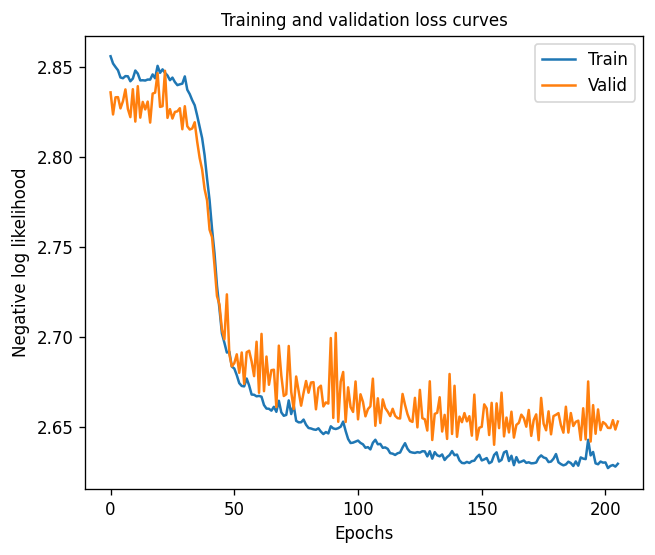

In [ ]:
# Get losses

train_losses = history.history['loss']
valid_losses = history.history['val_loss']

# Plot loss vs epoch
fig=plt.figure(figsize=(6, 5))
plt.plot(train_losses, label='Train')
plt.plot(valid_losses, label='Valid')
plt.legend(fontsize=10)
plt.xlabel("Epochs", fontsize=10)
plt.ylabel("Negative log likelihood", fontsize=10)
plt.title("Training and validation loss curves", fontsize=10)
plt.show()

(1500, 2)
['Normal', 'masked_autoregressive_flow']
(1500, 2) (1500, 2)
2 1


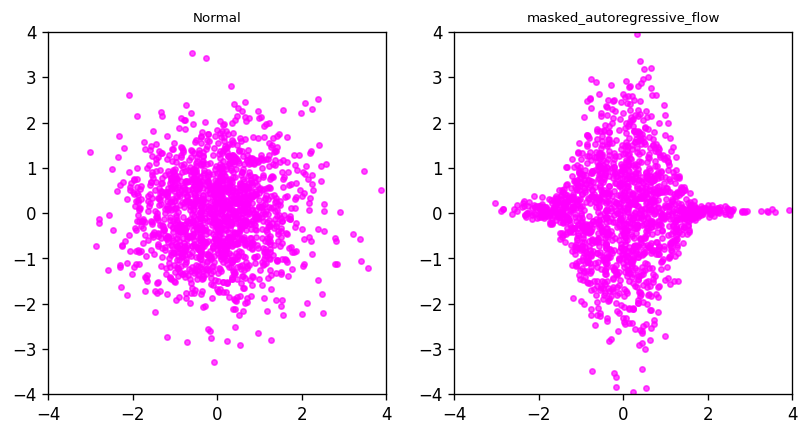

In [ ]:
# Make samples

x = base_distribution.sample((1500, 2))
print (x.shape)
names = [base_distribution.name, masked_auto_f_sigmoid.bijector.name]
print (names)
samples = [x, masked_auto_f_sigmoid.bijector.forward(x)]
print (samples[0].shape, samples[1].shape)

# Plot

scatter_plot(samples, names)

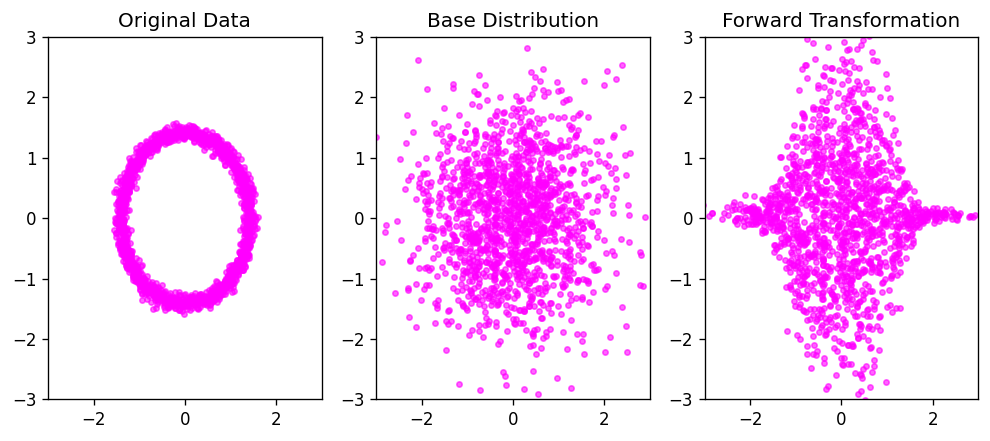

In [ ]:
# Define a plot routine

def visualize_training_data(samples):
    f, arr = plt.subplots(1, 3, figsize=(10, 4))
    names = ['Original Data', 'Base Distribution', 'Forward Transformation']
    samples = [tf.constant(X_circle_normed), samples[0], samples[-1]]

    for i in range(3):
        res = samples[i]
        X, Y = res[..., 0].numpy(), res[..., 1].numpy()
        arr[i].scatter(X, Y, s=10, color='magenta', alpha=0.6)
        arr[i].set_xlim([-3, 3])
        arr[i].set_ylim([-3, 3])
        arr[i].set_title(names[i])

visualize_training_data(samples)

In [ ]:
# Define a more expressive model

num_bijectors = 4
bijectors=[]

for i in range(num_bijectors):
    masked_auto_i = make_maf(hidden_units=[128, 128], activation='relu')
    bijectors.append(masked_auto_i)
    bijectors.append(tfb.Permute(permutation=[1, 0])) # data is only 2 dimension, so we interchange 0, 1 

flow_bijector = tfb.Chain(list(reversed(bijectors[:-1])))    

masked_auto_f_new = tfd.TransformedDistribution(tfd.Sample(base_distribution, sample_shape=[2]), flow_bijector,)
print ('check masked auto_f_new: ', masked_auto_f_new)

check masked auto_f_new:  tfp.distributions._TransformedDistribution("chain_of_masked_autoregressive_flow_of_permute_of_masked_autoregressive_flow_of_permute_of_masked_autoregressive_flow_of_permute_of_masked_autoregressive_flowSampleNormal", batch_shape=[], event_shape=[2], dtype=float32)


In [ ]:
history_new = train_dist_routine(masked_auto_f_new, n_epochs=800, n_disp=25)


 Epoch 1/800 
	 loss: 2.9348, val_loss: 2.8382

 Epoch 26/800 
	 loss: 2.1003, val_loss: 2.0205

 Epoch 51/800 
	 loss: 2.4997, val_loss: 2.3501

 Epoch 76/800 
	 loss: 1.7081, val_loss: 1.6939

 Epoch 101/800 
	 loss: 1.5527, val_loss: 1.4674

 Epoch 126/800 
	 loss: 1.4205, val_loss: 1.4482

 Epoch 151/800 
	 loss: 1.3558, val_loss: 1.3111

 Epoch 176/800 
	 loss: 1.5997, val_loss: 1.4137

 Epoch 201/800 
	 loss: 1.3453, val_loss: 1.3740
Epoch 219: early stopping


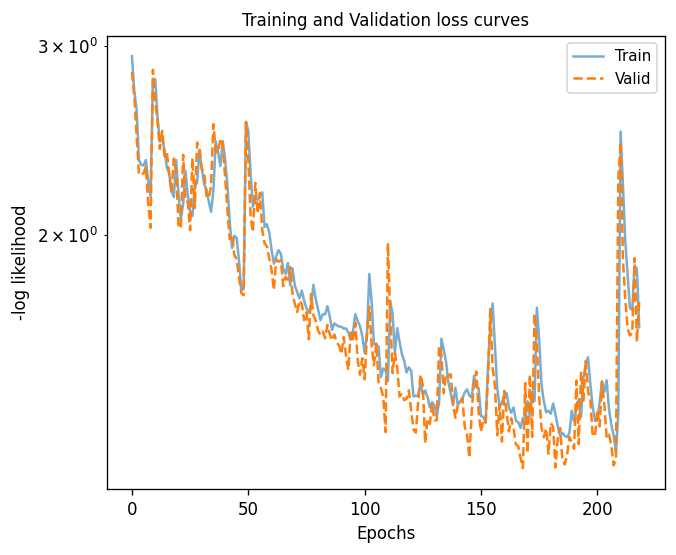

In [ ]:
train_losses_new = history_new.history['loss']
valid_losses_new = history_new.history['val_loss']

# Plot loss vs epoch
fig=plt.figure(figsize=(6, 5))
plt.plot(train_losses_new, label='Train', alpha=0.6)
plt.plot(valid_losses_new, label='Valid', ls='--')
plt.legend(fontsize=9)
plt.xlabel("Epochs", fontsize=10)
plt.ylabel("-log likelihood", fontsize=10)
plt.yscale('log')
plt.title("Training and Validation loss curves", fontsize=10)
plt.show()

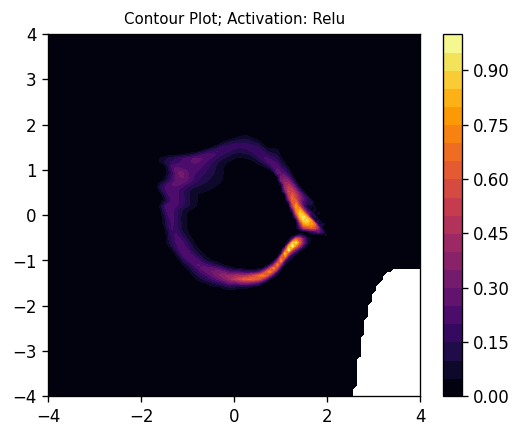

In [ ]:
contour_plot(masked_auto_f_new, 'Relu',)

8 8


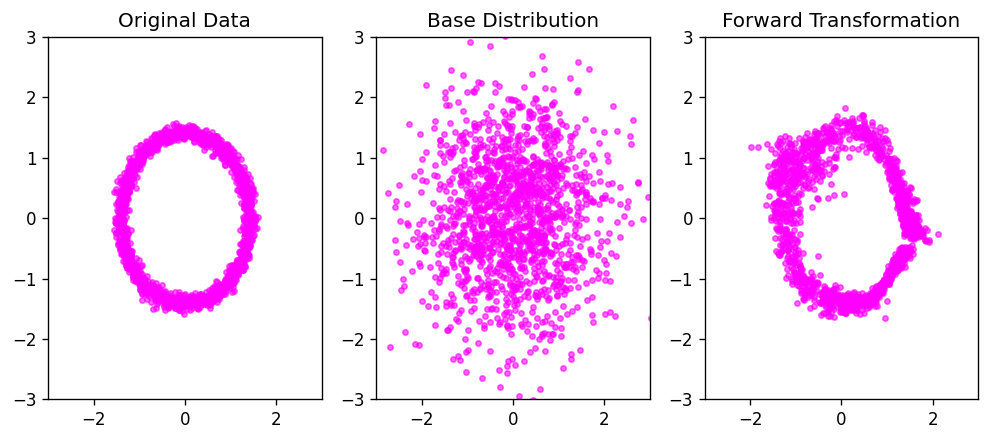

In [ ]:
# Make samples

def make_samples():
    x = base_distribution.sample((1500, 2))
    samples = [x]
    names = [base_distribution.name]
    for bijector in reversed(masked_auto_f_new.bijector.bijectors):
        x = bijector.forward(x)
        samples.append(x)
        names.append(bijector.name)
    return names, samples

names, samples = make_samples()
print (len(names), len(samples))

# Plot

visualize_training_data(samples)

In [ ]:
print ('bijector names: ', names)

bijector names:  ['Normal', 'masked_autoregressive_flow', 'permute', 'masked_autoregressive_flow', 'permute', 'masked_autoregressive_flow', 'permute', 'masked_autoregressive_flow']


4 2


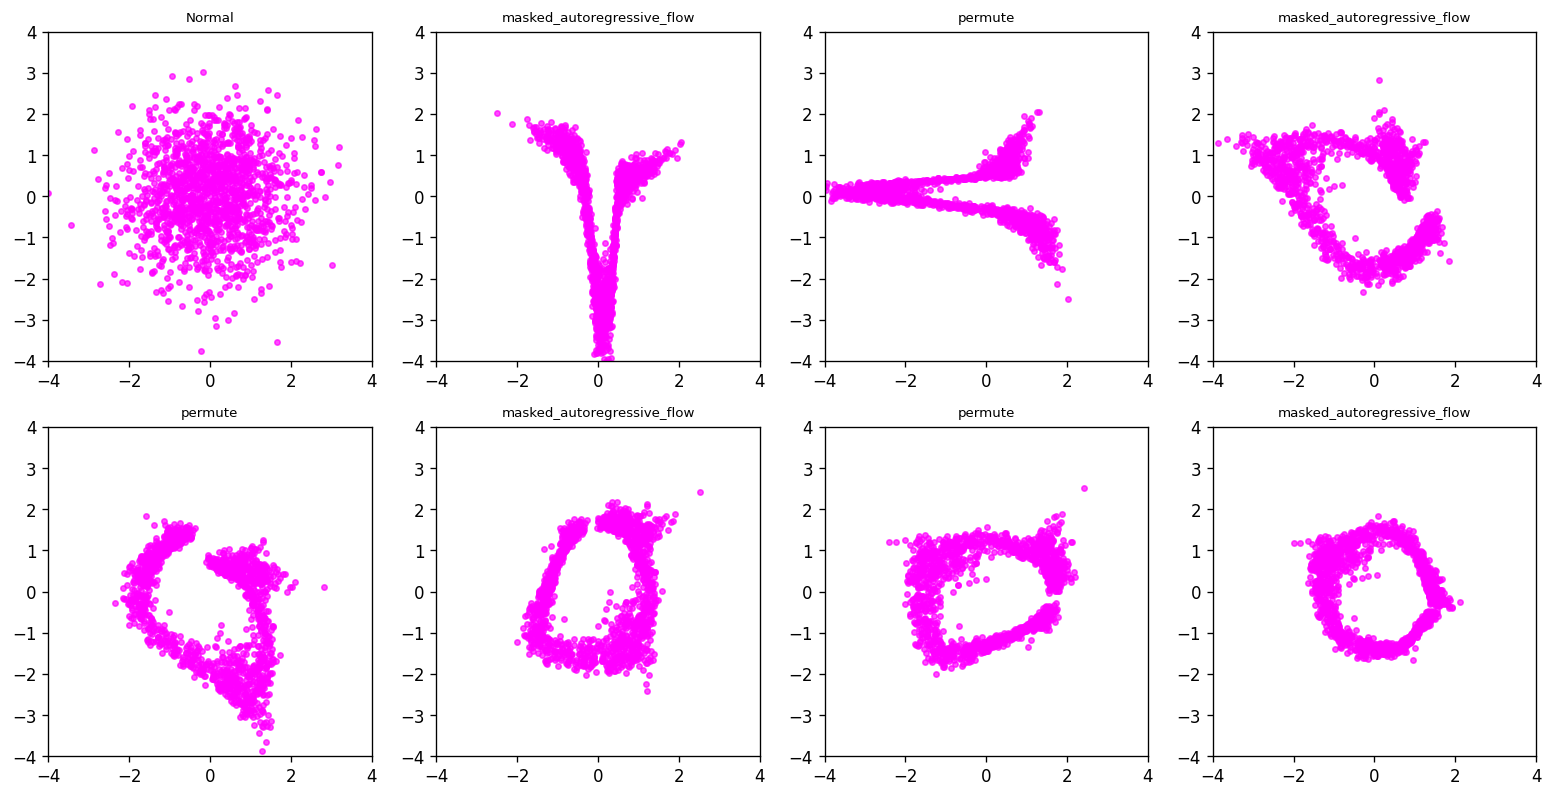

In [ ]:
scatter_plot(samples, names, 2)

### References 

[1] [Masked Autoregressive Flow for Density Estimation](https://arxiv.org/abs/1705.07057): Papamakarios, G. et.al. 

[2] [Density Estimation Using RealNVP](https://arxiv.org/abs/1605.08803): Dinh, L. et.al. 

[3] [Normalizing Flows: Part 2](https://blog.evjang.com/2018/01/nf2.html); Blog by Jang, E. 

[4] [Flow Based Models](https://lilianweng.github.io/posts/2018-10-13-flow-models/); Blog by Weng, L. 

[5] [TensorFlow Probability Library: Specially MAF](https://www.tensorflow.org/probability/api_docs/python/tfp/bijectors/MaskedAutoregressiveFlow). 